In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [4]:
def bonos_dbAlgebra(n,cn):
    bonos = 'SELECT TOP(' + str(n) + ") bono.Moneda, bono.TablaDesarrollo, bono.Base1 , bono.Base2, bono.FechaEmision, riesgo.Riesgo AS RiesgoInt FROM [dbAlgebra].[dbo].[TdNemoRF] AS bono , [dbAlgebra].[dbo].[VwRiesgoRF] AS riesgo WHERE bono.Nemotecnico = riesgo.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)
    return pd.DataFrame(bonos)

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
bonos = ajustes(bonos_dbAlgebra(3,cn))
bonos

,Moneda,TablaDesarrollo,Base1,Base2,FechaEmision,RiesgoInt,Convencion,Riesgo
0,UF,"1#01-06-2018#1,9068#9,09092#90,90908#10,99772|...",ACT,365,2017-12-01,3,ACT/365,AA
1,UF,"1#01-06-2018#1,9068#9,09092#90,90908#10,99772|...",ACT,365,2017-12-01,3,ACT/365,AA
2,UF,"1#01-09-1992#3,19884#0#100#3,19884|2#01-03-199...",ACT,365,1992-03-01,2,ACT/365,AA


In [7]:
derivados = derivados_dBDerivados(5, cn)
derivados["Derivado"][1].genera_flujos()
derivados["Derivado"][1].valoriza_flujos()
derivados["Derivado"][1].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

C:\Users\groso\Desktop\PracticaV3\Practica\Intento\Cartera\DerivadosTipos\DerivadosSCC.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_cartera.MonedaActivo[0] = "CLP"


,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1367,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,8.662021e+07,8.587635e+07,CLP,CLP
1,1367,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,7.098801e+07,6.988231e+07,CLP,CLP
2,1367,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,9.568963e+07,9.330633e+07,CLP,CLP
3,1367,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,1.008449e+10,9.750935e+09,CLP,CLP
4,1367,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,7.304466e+07,7.241738e+07,CLP,CLP
5,1367,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,7.385030e+07,7.270002e+07,CLP,CLP
6,1367,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,7.264186e+07,7.083260e+07,CLP,CLP
7,1367,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,1.007385e+10,9.740649e+09,CLP,CLP


In [8]:
acciones = historico("DE000DWS2D90", "A", 60)


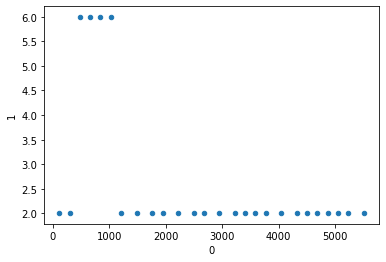

In [9]:
cartera = Cartera(acciones, bonos, derivados,'CLP', datetime.date(2019,2,1), cn, 60)

In [10]:
print(cartera.get_historicos_totales())

    UF#119#AA  UF#299#AA  UF#470#AA  UF#651#AA  UF#830#AA  UF#1011#AA  \
0    1.017973   1.045775   1.072890   1.102356   1.132293    1.163392   
1    1.018581   1.047345   1.075431   1.105995   1.137019    1.169203   
2    1.018654   1.047534   1.075728   1.106397   1.137588    1.170021   
3    1.018712   1.047684   1.075970   1.106743   1.138041    1.170589   
4    1.018747   1.047774   1.076115   1.106950   1.138311    1.170925   
5    1.018304   1.046629   1.074281   1.104371   1.134943    1.166695   
6    1.018243   1.046471   1.074013   1.103955   1.134333    1.165832   
7    1.018205   1.046374   1.073818   1.103588   1.133823    1.165228   
8    1.018058   1.045995   1.073245   1.102863   1.132968    1.164260   
9    1.017833   1.045413   1.072321   1.101582   1.131291    1.162127   
10   1.018071   1.046028   1.073298   1.102937   1.133054    1.164344   
11   1.018082   1.046057   1.073345   1.103004   1.133141    1.164453   
12   0.996159   0.987564   0.975223   0.956039   0.

In [11]:
print(cartera.get_retornos_totales())

       UF#119#AA  UF#299#AA  UF#470#AA  UF#651#AA  UF#830#AA  UF#1011#AA  \
0   0.000000e+00   0.000000   0.000000   0.000000   0.000000    0.000000   
1   8.869130e-04   0.001790   0.002656   0.003585   0.004454    0.005273   
2   1.684315e-04   0.000277   0.000372   0.000461   0.000597    0.000796   
3   1.537798e-04   0.000240   0.000322   0.000409   0.000495    0.000582   
4   1.308385e-04   0.000183   0.000232   0.000284   0.000334    0.000384   
5  -3.386966e-04  -0.000997  -0.001609  -0.002236  -0.002867   -0.003522   
6   2.297592e-04   0.000139   0.000040  -0.000087  -0.000248   -0.000451   
7   5.974034e-05   0.000004  -0.000085  -0.000236  -0.000352   -0.000422   
8  -4.747648e-05  -0.000265  -0.000437  -0.000561  -0.000658   -0.000734   
9  -1.251324e-04  -0.000461  -0.000765  -0.001065  -0.001384   -0.001737   
10  3.307539e-04   0.000685   0.001007   0.001326   0.001654    0.002002   
11  3.011275e-04   0.000318   0.000334   0.000350   0.000367    0.000384   
12 -2.167233

In [12]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.0009720356291826534
